<a href="https://colab.research.google.com/github/VidhyaMadhavi/EIP3/blob/master/1_Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/EIP3-Gan')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

1_Download_data_from_kaggle.ipynb  generator_model_020.h5
1_Gan.ipynb			   generator_model_030.h5
celeba-dataset			   generator_model_040.h5
generated_faces.png		   generator_model_050.h5
generated_plot_e010.png		   generator_model_060.h5
generated_plot_e020.png		   generator_model_070.h5
generated_plot_e030.png		   generator_model_080.h5
generated_plot_e040.png		   generator_model_090.h5
generated_plot_e050.png		   generator_model_100.h5
generated_plot_e060.png		   img_align_celeba.npz
generated_plot_e070.png		   kaggle.json
generated_plot_e080.png		   latent_points.npz
generated_plot_e090.png		   subset1
generated_plot_e100.png		   subset1.zip
generator_model_010.h5		   temp


In [0]:
!unzip subset1.zip

In [0]:
!ls -ltr subset1 | wc -l

10308


In [0]:
!mv subset1/*.*  celeba-dataset/img_align_celeba

In [0]:
!ls -ltr  celeba-dataset/img_align_celeba  | wc -l

21201


In [0]:
!mv temp/*.*  celeba-dataset/img_align_celeba/

Prepare CelebA Faces Dataset

- use the Pillow library to load a given image file
- convert it to RGB format (if needed) and 
- return an array of pixel data

In [0]:
# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import numpy as np

Using TensorFlow backend.


In [0]:
# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot


In [0]:
import os
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = np.asarray(image)
	return pixels

- we can enumerate the directory of images, load each as an array of pixels in turn
- and return an array with all of the images.
- There are 200K images in the dataset
- images are more than we need so we can also limit the number of images to load with an argument. 
- The load_faces() function below implements this.

In [0]:

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	faces = list()
	# enumerate files
	for filename in os.listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# store
		faces.append(pixels)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return np.asarray(faces)

- once the images are loaded, w
- e can plot them using the imshow() function from the matplotlib library.
- The plot_faces() function below does this, plotting images arranged into in a square.

In [0]:
# plot a list of loaded faces
def plot_faces(faces, n):
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(faces[i])
  plt.show()

Load the Images

In [0]:
# !ls 'celeba-dataset/img_align_celeba/'

In [0]:
directory = 'celeba-dataset/img_align_celeba/'

In [0]:
# directory that contains all images
directory = 'celeba-dataset/img_align_celeba/'
# load and extract all faces
faces = load_faces(directory, 25)
print('Loaded: ', faces.shape)
# plot faces
plot_faces(faces, 5)

When working with a GAN, it is easier to model a dataset if all of the images are small and square in shape.
Further, as we are only interested in the face in each photo, and not the background, we can perform face detection and extract only the face before resizing the result to a fixed size.
There are many ways to perform face detection. In this case, we will use a pre-trained Multi-Task Cascaded Convolutional Neural Network, or MTCNN. This is a state-of-the-art deep learning model for face detection

In [0]:
!sudo pip install mtcnn

In [0]:
import mtcnn
print(mtcnn.__version__)
from mtcnn.mtcnn import MTCNN

In [0]:
# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
	# detect face in the image
	faces = model.detect_faces(pixels)
	# skip cases where we could not detect a face
	if len(faces) == 0:
		return None
	# extract details of the face
	x1, y1, width, height = faces[0]['box']
	# force detected pixel values to be positive (bug fix)
	x1, y1 = abs(x1), abs(y1)
	# convert into coordinates
	x2, y2 = x1 + width, y1 + height
	# retrieve face pixels
	face_pixels = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face_pixels)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

We can now update the load_faces() function to extract the face from the loaded photo and store that in the list of faces returned.

In [0]:
# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	# prepare model
	model = MTCNN()
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# get face
		face = extract_face(model, pixels)
		if face is None:
			continue
		# store
		faces.append(face)
		print(len(faces), face.shape)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return asarray(faces)

In [0]:
directory

## Converting the Input Images to Array

In [0]:
# example of extracting and resizing faces into a new dataset
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
	# detect face in the image
	faces = model.detect_faces(pixels)
	# skip cases where we could not detect a face
	if len(faces) == 0:
		return None
	# extract details of the face
	x1, y1, width, height = faces[0]['box']
	# force detected pixel values to be positive (bug fix)
	x1, y1 = abs(x1), abs(y1)
	# convert into coordinates
	x2, y2 = x1 + width, y1 + height
	# retrieve face pixels
	face_pixels = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face_pixels)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	# prepare model
	model = MTCNN()
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# get face
		face = extract_face(model, pixels)
		if face is None:
			continue
		# store
		faces.append(face)
		print(len(faces), face.shape)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return asarray(faces)

# directory that contains all images
directory = 'celeba-dataset/img_align_celeba/'
# load and extract all faces
all_faces = load_faces(directory, 21201)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('img_align_celeba.npz', all_faces)

1 (80, 80, 3)
2 (80, 80, 3)
3 (80, 80, 3)
4 (80, 80, 3)
5 (80, 80, 3)
6 (80, 80, 3)
7 (80, 80, 3)
8 (80, 80, 3)
9 (80, 80, 3)
10 (80, 80, 3)
11 (80, 80, 3)
12 (80, 80, 3)
13 (80, 80, 3)
14 (80, 80, 3)
15 (80, 80, 3)
16 (80, 80, 3)
17 (80, 80, 3)
18 (80, 80, 3)
19 (80, 80, 3)
20 (80, 80, 3)
21 (80, 80, 3)
22 (80, 80, 3)
23 (80, 80, 3)
24 (80, 80, 3)
25 (80, 80, 3)
26 (80, 80, 3)
27 (80, 80, 3)
28 (80, 80, 3)
29 (80, 80, 3)
30 (80, 80, 3)
31 (80, 80, 3)
32 (80, 80, 3)
33 (80, 80, 3)
34 (80, 80, 3)
35 (80, 80, 3)
36 (80, 80, 3)
37 (80, 80, 3)
38 (80, 80, 3)
39 (80, 80, 3)
40 (80, 80, 3)
41 (80, 80, 3)
42 (80, 80, 3)
43 (80, 80, 3)
44 (80, 80, 3)
45 (80, 80, 3)
46 (80, 80, 3)
47 (80, 80, 3)
48 (80, 80, 3)
49 (80, 80, 3)
50 (80, 80, 3)
51 (80, 80, 3)
52 (80, 80, 3)
53 (80, 80, 3)
54 (80, 80, 3)
55 (80, 80, 3)
56 (80, 80, 3)
57 (80, 80, 3)
58 (80, 80, 3)
59 (80, 80, 3)
60 (80, 80, 3)
61 (80, 80, 3)
62 (80, 80, 3)
63 (80, 80, 3)
64 (80, 80, 3)
65 (80, 80, 3)
66 (80, 80, 3)
67 (80, 80, 3)
68 (

he prepared dataset can then be loaded any time, as follows.

In [0]:
# load the prepared dataset
from numpy import load
# load the face dataset
data = load('img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

Loaded:  (21174, 80, 80, 3)


Develop a Generative Adversarial Network

In [0]:
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [0]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [0]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# Training the Model

In [0]:


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/165, d1=0.700, d2=0.695 g=0.693


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/165, d1=0.573, d2=0.696 g=0.692
>1, 3/165, d1=0.266, d2=0.708 g=0.686
>1, 4/165, d1=0.028, d2=0.744 g=0.680
>1, 5/165, d1=0.004, d2=0.760 g=0.685
>1, 6/165, d1=0.006, d2=0.744 g=0.698
>1, 7/165, d1=0.026, d2=0.711 g=0.711
>1, 8/165, d1=0.019, d2=0.682 g=0.740
>1, 9/165, d1=0.005, d2=0.652 g=0.837
>1, 10/165, d1=0.010, d2=0.587 g=1.002
>1, 11/165, d1=0.019, d2=0.518 g=1.140
>1, 12/165, d1=0.001, d2=0.391 g=1.654
>1, 13/165, d1=0.015, d2=0.240 g=2.256
>1, 14/165, d1=0.000, d2=0.073 g=3.755
>1, 15/165, d1=0.000, d2=0.014 g=5.097
>1, 16/165, d1=0.000, d2=0.018 g=5.724
>1, 17/165, d1=0.000, d2=1.935 g=8.578
>1, 18/165, d1=0.000, d2=0.000 g=15.051
>1, 19/165, d1=0.001, d2=0.000 g=15.922
>1, 20/165, d1=0.483, d2=0.459 g=0.910
>1, 21/165, d1=0.000, d2=1.221 g=1.135
>1, 22/165, d1=0.000, d2=0.697 g=1.424
>1, 23/165, d1=0.000, d2=0.667 g=0.929
>1, 24/165, d1=0.006, d2=0.470 g=1.656
>1, 25/165, d1=0.004, d2=0.112 g=4.236
>1, 26/165, d1=0.163, d2=0.114 g=3.251
>1, 27/165, d1=0.025, d2=0.087 

In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [0]:
# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

## Explore the Latent Space for Generated Faces

Load Model and Generate Faces

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


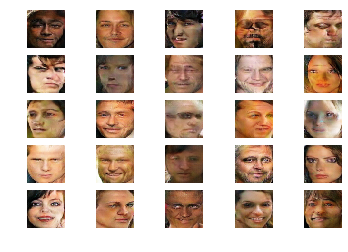

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
# model = load_model('generator_model_030.h5')
model = load_model('generator_model_080.h5')

# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)

Interpolate Between Generated Faces

In [0]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


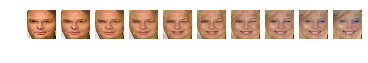

In [0]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		pyplot.subplot(1, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# generate points in latent space
pts = generate_latent_points(100, 20)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

We can update the example to repeat this process multiple times so we can see the transition between multiple generated faces on a single plot.
The complete example is listed below.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


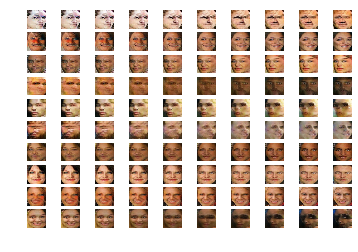

In [0]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10)

In these cases, we have performed a linear interpolation which assumes that the latent space is uniformly distributed hypercube. Technically, our chosen latent space is a 100-dimension hypersphere or multimodal Gaussian distribution.
There is a mathematical function called the spherical linear interpolation function, or ‘Slerp,’ that should be used when interpolating this space to ensure the curving of the space is taken into account.

In [0]:
# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


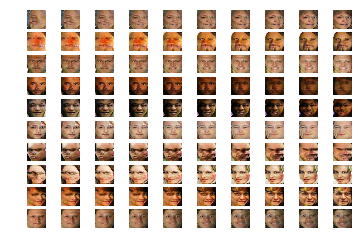

In [0]:
# example of interpolating between generated faces
from numpy import asarray
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# spherical linear interpolation (slerp)
def slerp(val, low, high):
	omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
	so = sin(omega)
	if so == 0:
		# L'Hopital's rule/LERP
		return (1.0-val) * low + val * high
	return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = slerp(ratio, p1, p2)
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# generate points in latent space
n = 20
pts = generate_latent_points(100, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = model.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = vstack((results, X))
# plot the result
plot_generated(results, 10)

## Perform Vector Arithmetic With Faces

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import savez_compressed

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.savefig('generated_faces.png')
	pyplot.close()

# load model
model = load_model('generator_model_080.h5')
# generate points in latent space
latent_points = generate_latent_points(100, 100)
# save points
savez_compressed('latent_points.npz', latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# save plot
plot_generated(X, 10)

W0814 16:41:20.912533 140284989704064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 16:41:20.981402 140284989704064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 16:41:21.227398 140284989704064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 16:41:21.228869 140284989704064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0814 16:41:21.236283 140284989704064 depre

- ### loads the model, 
- ### generates faces
- ### saves the latent vectors and generated faces.
- ### The latent vectors are saved to a compressed NumPy array with the filename ‘latent_points.npz‘. 

The 100 generated faces are plotted in a 10×10 grid and saved in a file named ‘generated_faces.png‘.
In this case, we have a good collection of faces to work with. Each face has an index that we can use to retrieve the latent vector. 
For example, the first face is 1, which corresponds to the first vector in the saved array (index 0).

### smiling woman - neutral woman + neutral man = smiling man

In [0]:
# retrieve specific points
smiling_woman_ix = [92, 98, 99]
neutral_woman_ix = [9, 21, 79]
neutral_man_ix = [10, 30, 45]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']

In [0]:
type(data)
for i in data:
  print(i)
points.shape
points[0]

arr_0


array([-2.1484265 , -0.57092201, -0.57537682, -0.34646752,  1.2109675 ,
        0.41478679,  0.21451981, -0.90253145,  1.32705128,  0.11800208,
       -1.25242813,  1.85212135,  1.19958334, -0.4226297 ,  1.13021107,
       -1.06139665,  0.28607041, -0.82457961,  0.60411106,  0.58745923,
       -1.85936399,  1.40009715,  1.57183399, -0.41500486, -0.19270587,
        0.83320506,  1.72294251,  0.65476577,  0.8207307 , -0.37567134,
       -0.03443396,  0.31850958, -2.15287719, -0.08942749,  0.2654297 ,
        0.22573535,  1.08207287, -0.0591424 ,  1.17955559,  0.10135532,
        0.25252367, -0.89001432, -1.59800763,  1.82090898, -1.27748428,
       -1.41628238, -0.43799947,  0.74088327, -0.77658755, -0.01506627,
       -0.45092625,  0.52958385,  1.23263615,  0.50797895, -0.56571159,
       -1.11545312,  0.06021411, -0.23752919,  0.99322597,  0.00537528,
        1.34425623, -0.18389187,  1.03599162,  1.53538176, -0.28133066,
       -1.17452878,  0.56178941, -0.43226493,  0.60161157, -1.50

In [0]:
# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = np.mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

In [0]:
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images,  3)

In [0]:
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = np.expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Make the Neutral Women Smile

 the complete example is listed below.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


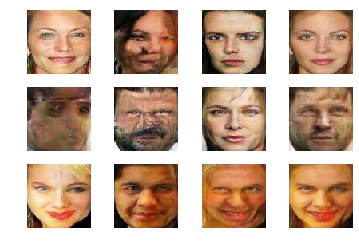

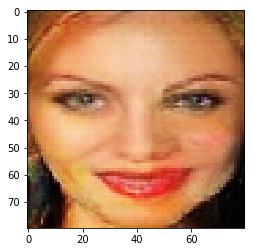

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [92, 98, 99]
neutral_woman_ix = [9, 21, 79]
neutral_man_ix = [10, 30, 45]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images, 3, 4)
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

#### select 3 simling women 
#### get the vectors of 3 simling women
#### average those vectors
#### this average vector becomes the latent vector of smiling women
#### Now display the 3 original vectors and the average vector of smiling women
####  Perform the arithmetic operation with average vectors


#  Women_Black_hair  -  Women_White_hair + Man_white_hair



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


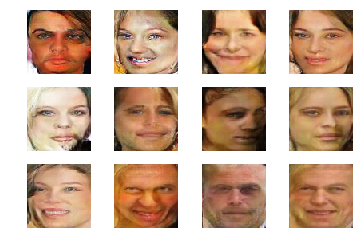

smiling_woman[-1] : [-5.38871846e-01 -4.75476645e-01  1.02427251e+00  1.34620413e+00
  4.09018905e-01 -3.57499388e-01  4.53136214e-01 -4.41286766e-01
 -5.31326176e-01 -6.69933091e-01  1.43151959e-01 -2.79118164e-01
 -1.51423568e-01 -6.72017850e-01 -2.07318277e-01 -4.66160086e-01
 -6.37299478e-01 -7.06961577e-01 -1.05852689e+00 -9.90519601e-01
  4.03750807e-01  2.86756115e-01 -6.50127118e-01 -9.59086776e-02
  4.53960169e-01 -7.42890106e-01  3.36471827e-01  2.06237732e-01
 -9.58066692e-01  4.45071582e-02  4.98338293e-01  7.93078123e-02
  8.53410781e-01  7.70364859e-01 -2.43779679e-02 -4.43855270e-01
 -1.97515739e-01  2.75924143e-01 -7.38285218e-01  1.54840795e-01
 -2.78311663e-01 -2.95949378e-01  8.75622789e-04 -2.36179261e-01
 -1.85561638e-01  4.17119946e-01  8.55417290e-01 -5.43780307e-01
 -5.41967025e-01  2.52271504e-02  4.51796093e-01 -4.69990197e-02
  2.06096704e-01  7.61520668e-01  2.48742579e-01 -7.91126040e-01
  1.02718673e+00 -7.57879744e-01  3.16159704e-01  8.66950011e-01
 -1.9

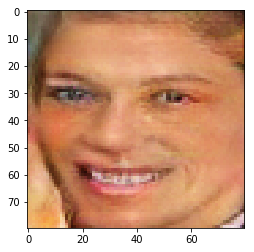

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [83, 54, 73]    # women-black-hair
neutral_woman_ix = [13, 63, 51]   # women-white-hair
neutral_man_ix = [56, 45, 52]     # Man-White-hair
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# left angle faces    - Center angle faces  + right angle faces

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


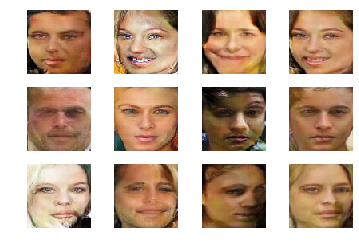

smiling_woman[-1] : [-1.86967624e-01 -4.17484282e-01  1.66514243e+00  9.69690112e-01
  2.08394451e-01 -3.90286426e-01 -3.39694983e-01 -6.20607269e-01
 -7.89179386e-01 -6.12194336e-01  8.09141446e-01 -5.64188586e-01
  4.97993037e-01 -9.11281836e-01 -9.01103422e-01 -4.56482339e-01
 -5.50375635e-01  1.35511314e-01 -7.72926203e-01 -4.13147098e-01
  5.38105938e-01 -3.15520813e-01 -4.61446272e-01 -4.98245918e-01
 -7.14083002e-01 -8.28202621e-01  1.10403466e+00  7.68034126e-01
 -2.64975440e-01 -1.97826653e-01 -2.41122507e-01  1.86345200e-01
  9.99445324e-01  2.18876396e-01 -1.75606542e-01 -1.52344655e-01
 -6.50278891e-01 -1.38622063e-01 -1.47251563e-01  4.87417715e-01
  4.25935923e-02 -9.43836295e-01  3.93053025e-01  1.53112271e-01
 -1.30744352e-01  6.16758561e-01  6.15423706e-01 -2.68866993e-01
 -5.66553511e-01  6.78430124e-01  4.77477352e-01  2.78172474e-01
  4.75562513e-01  5.47183093e-02  9.67249892e-01 -1.30862996e+00
  7.94601077e-01 -4.77837972e-01 -1.46878144e-01  1.07240636e+00
  5.8

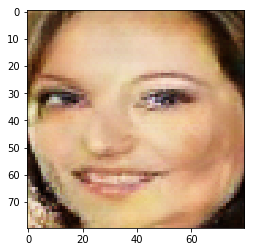

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [41, 54, 73]    # left angle faces 
neutral_woman_ix = [52, 35, 67]  #Center angle faces
neutral_man_ix =  [13, 63, 51]     # right angle faces
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [41, 54, 73]    # left angle faces 
neutral_woman_ix = [52, 35, 51]  #Center angle faces
neutral_man_ix =  [13, 63, 51]     # right angle faces
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

- Monster with 3 eyes, 2 noses , 2 mouths

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


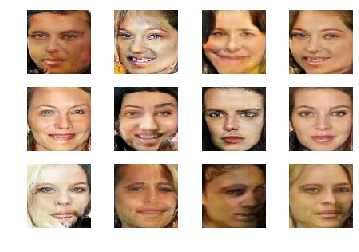

smiling_woman[-1] : [-1.86967624e-01 -4.17484282e-01  1.66514243e+00  9.69690112e-01
  2.08394451e-01 -3.90286426e-01 -3.39694983e-01 -6.20607269e-01
 -7.89179386e-01 -6.12194336e-01  8.09141446e-01 -5.64188586e-01
  4.97993037e-01 -9.11281836e-01 -9.01103422e-01 -4.56482339e-01
 -5.50375635e-01  1.35511314e-01 -7.72926203e-01 -4.13147098e-01
  5.38105938e-01 -3.15520813e-01 -4.61446272e-01 -4.98245918e-01
 -7.14083002e-01 -8.28202621e-01  1.10403466e+00  7.68034126e-01
 -2.64975440e-01 -1.97826653e-01 -2.41122507e-01  1.86345200e-01
  9.99445324e-01  2.18876396e-01 -1.75606542e-01 -1.52344655e-01
 -6.50278891e-01 -1.38622063e-01 -1.47251563e-01  4.87417715e-01
  4.25935923e-02 -9.43836295e-01  3.93053025e-01  1.53112271e-01
 -1.30744352e-01  6.16758561e-01  6.15423706e-01 -2.68866993e-01
 -5.66553511e-01  6.78430124e-01  4.77477352e-01  2.78172474e-01
  4.75562513e-01  5.47183093e-02  9.67249892e-01 -1.30862996e+00
  7.94601077e-01 -4.77837972e-01 -1.46878144e-01  1.07240636e+00
  5.8

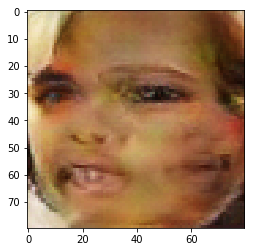

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [41, 54, 73]    # left angle faces 
neutral_woman_ix = [92, 43, 99]  #Center angle faces
neutral_man_ix =  [13, 63, 51]     # right angle faces
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

## dark front face - clear front face with black hair + clear front face with white hair = A Man with new features with White Hair

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


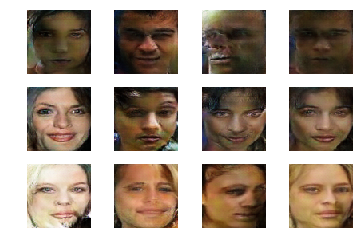

smiling_woman[-1] : [-0.7303537   0.10604628  0.05581894  0.24629481  0.21829786 -0.72987149
  0.43169943 -0.5719889  -0.51356598  0.12828598  0.09079492  0.25519062
  1.93930885 -0.7141241  -0.02204121  0.28775884  0.04976867 -0.19043831
 -0.91160956  0.87612618 -1.11005143 -0.14726009  1.30927841 -0.38018085
  0.67103579 -0.64277921 -0.06530539  1.20402748  0.71945079  0.60810085
  0.70957442  0.21824    -0.71502244 -0.10751622  0.39218292  0.95032949
  0.54708553 -0.14546197  0.85724852 -0.77345869 -0.61219544  0.03604
 -0.40519557  0.29157809  0.26274434  0.76359659 -0.85066455 -0.66418353
  0.40093333 -1.11524788 -0.66152918 -0.15245471 -1.00021817 -1.42335856
 -0.61361259  0.51947476 -0.01114789  0.23768833 -0.04220855 -0.82178754
 -0.373335   -0.16400216  0.51019492  1.82417383 -0.17382081  0.04672817
 -0.24965952 -0.24684049 -0.11501017 -0.05639579 -0.50346817 -0.31874678
 -1.00021012  1.08407821  0.71106983  0.97951395 -0.05584055  1.153738
  0.45603865 -0.05160656 -0.19435232

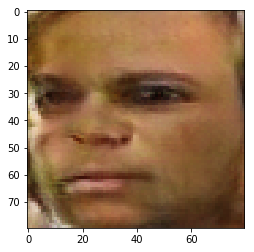

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [1, 11, 3]    # dark photo
neutral_woman_ix = [66, 67, 77]  #Center angle faces
neutral_man_ix =  [13, 63, 51]     # right angle faces
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

## Same input as above - create a dark faced man
## dark front face +  clear front face  -  clear front face   = dark front face

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


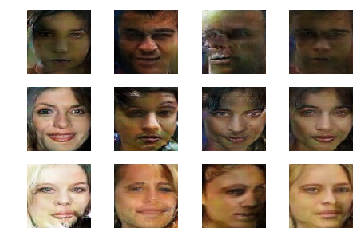

smiling_woman[-1] : [-0.7303537   0.10604628  0.05581894  0.24629481  0.21829786 -0.72987149
  0.43169943 -0.5719889  -0.51356598  0.12828598  0.09079492  0.25519062
  1.93930885 -0.7141241  -0.02204121  0.28775884  0.04976867 -0.19043831
 -0.91160956  0.87612618 -1.11005143 -0.14726009  1.30927841 -0.38018085
  0.67103579 -0.64277921 -0.06530539  1.20402748  0.71945079  0.60810085
  0.70957442  0.21824    -0.71502244 -0.10751622  0.39218292  0.95032949
  0.54708553 -0.14546197  0.85724852 -0.77345869 -0.61219544  0.03604
 -0.40519557  0.29157809  0.26274434  0.76359659 -0.85066455 -0.66418353
  0.40093333 -1.11524788 -0.66152918 -0.15245471 -1.00021817 -1.42335856
 -0.61361259  0.51947476 -0.01114789  0.23768833 -0.04220855 -0.82178754
 -0.373335   -0.16400216  0.51019492  1.82417383 -0.17382081  0.04672817
 -0.24965952 -0.24684049 -0.11501017 -0.05639579 -0.50346817 -0.31874678
 -1.00021012  1.08407821  0.71106983  0.97951395 -0.05584055  1.153738
  0.45603865 -0.05160656 -0.19435232

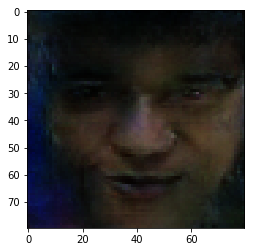

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [1, 11, 3]    # dark photo
neutral_woman_ix = [66, 67, 77]  #Center angle faces
neutral_man_ix =  [13, 63, 51]     # right angle faces
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] + neutral_woman[-1] - neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [1, 11, 3]    # dark photo
neutral_woman_ix = [66, 67, 77]  #Center angle faces
neutral_man_ix =  [13, 63, 51]     # right angle faces
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] + neutral_woman[-1] - neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

#Make New Hair Style to Women  (Get the Hair style from a man)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


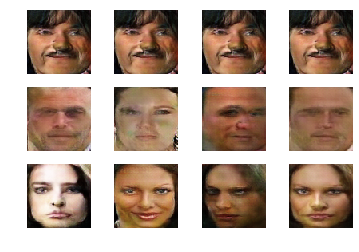

(100,)


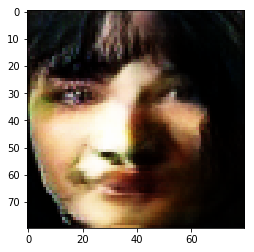

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [42, 42, 42]    # man  with moutash
neutral_woman_ix = [52, 61, 62]  # man with out moutash
neutral_man_ix =  [49, 64, 53]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

#  change angle of the same lady from right to left
# right face lady - center face  + left face 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


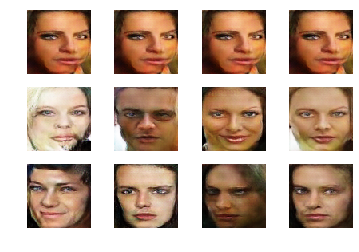

(100,)


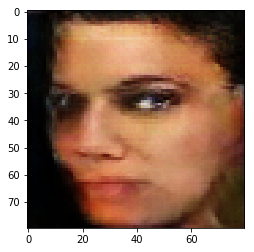

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [2, 2, 2]    # man  with moutash
neutral_woman_ix = [13, 94, 64]  # man with out moutash
neutral_man_ix =  [4, 99, 53]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Make new hair style to the lady

# fair front hair cut man - dark face lady  +  fair lady with out front hair cut   = Fair lady with front hair cut 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


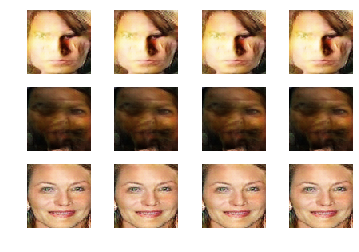

(100,)


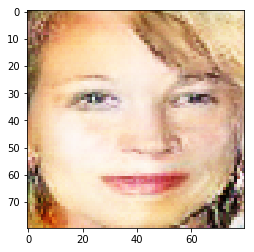

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [69, 69, 69]    # man  with moutash
neutral_woman_ix = [20, 20, 20]  # man with out moutash
neutral_man_ix =  [92, 92, 92]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Grow Moutash to dark man

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


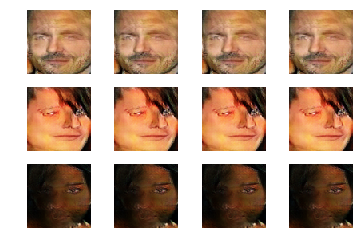

(100,)


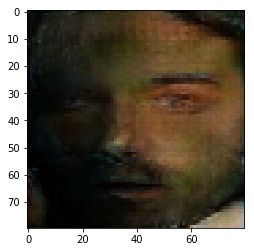

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [70, 70, 70]    # man  with moutash
neutral_woman_ix = [20, 20, 20]  # man with out moutash
neutral_man_ix =  [92, 92, 92]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [20, 20, 20]  # man with out moutash    # man  with moutash
neutral_woman_ix = 
neutral_man_ix =   [91, 11, 82]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

## Give more smile to the first Women and change her hair from black to White(like second women) and change her skin color same as second women

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


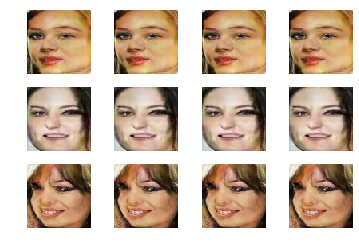

(100,)


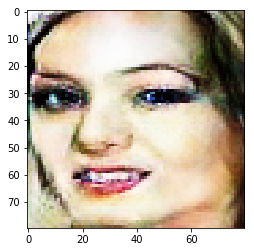

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [61, 61, 61]  # man with out moutash    # man  with moutash
neutral_woman_ix = [21, 21, 21]
neutral_man_ix =   [74, 74, 74]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = smiling_woman[-1] + neutral_woman[-1] + neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

## Grown more black hair for the same photo generated on the last step

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


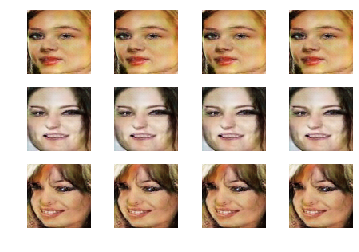

(100,)


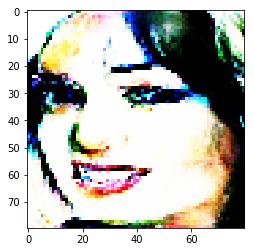

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [61, 61, 61]  # man with out moutash    # man  with moutash
neutral_woman_ix = [21, 21, 21]
neutral_man_ix =   [74, 74, 74]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = 2* smiling_woman[-1] + 2 * neutral_woman[-1] + 8 * neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Grow more hair

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


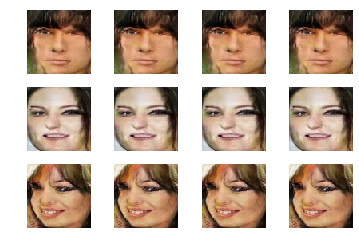

(100,)


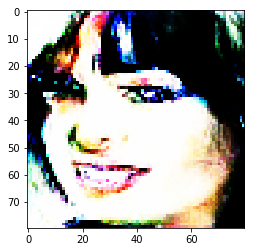

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [4, 4 , 4]  # man with out moutash    # man  with moutash
neutral_woman_ix = [21, 21, 21]
neutral_man_ix =   [74, 74, 74]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector = 2* smiling_woman[-1] + 2 * neutral_woman[-1] + 8 * neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Convert the women from the last step to a man

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


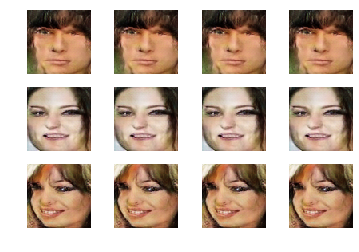

(100,)


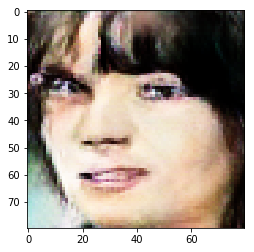

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [4, 4 , 4]  # man with out moutash    # man  with moutash
neutral_woman_ix = [21, 21, 21]
neutral_man_ix =   [74, 74, 74]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector =  smiling_woman[-1] +  neutral_woman[-1] +   neutral_man[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Convert Women to man, then man to man with moutash, then more moutash and beard

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


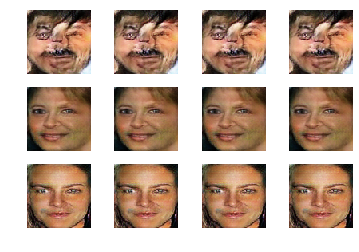

(100,)


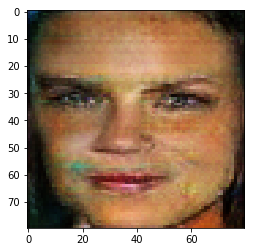

(100,)


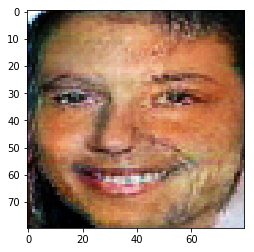

(100,)


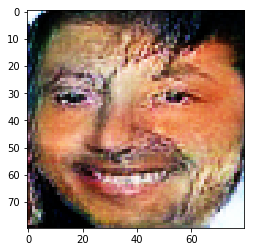

(100,)


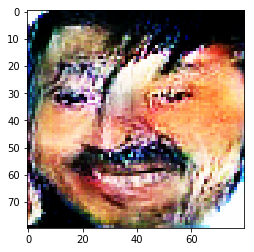

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [56, 56 , 56]  # man with out moutash    # man  with moutash
neutral_woman_ix = [57, 57, 57]
neutral_man_ix =   [58, 58, 58]     # female 
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])
result_vector =   neutral_woman[-1]   + neutral_man[-1] -  smiling_woman[-1]

print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =   neutral_woman[-1]   + neutral_man[-1] +  smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =   neutral_woman[-1]   + neutral_man[-1] +  2* smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =   neutral_woman[-1]   + neutral_man[-1] +  4* smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()




# Create a new man and then convert the man to women

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


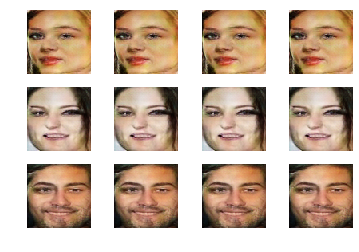

(100,)


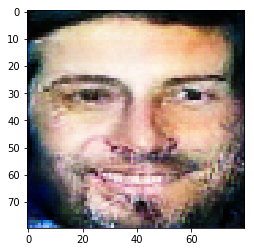

(100,)


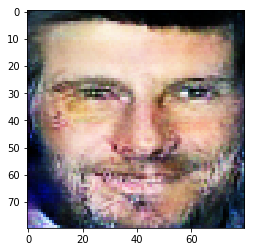

(100,)


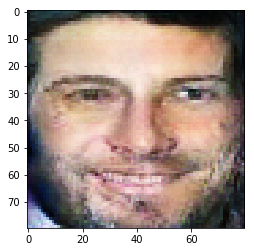

(100,)


(100,)


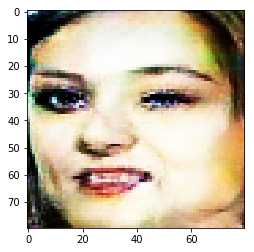

(100,)


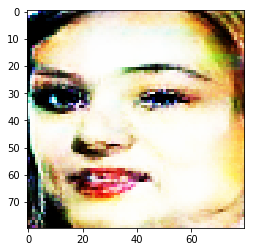

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [61, 61, 61]
neutral_woman_ix = [21, 21, 21] #[1, 21, 3]
neutral_man_ix = [7, 7, 7]  # [7, 30, 45]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)
# # smiling woman - neutral woman + neutral man = smiling man
# print("smiling_woman[-1] :", smiling_woman[-1])

result_vector =    neutral_woman[-1]   + 2* neutral_man[-1] - smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =   neutral_woman[-1]   + neutral_man[-1] - 2* smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =   neutral_woman[-1]   + neutral_man[-1] -  smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =   neutral_woman[-1]   + neutral_man[-1] +  smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =   neutral_woman[-1]   + neutral_man[-1] +  2* smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =   neutral_woman[-1]   + neutral_man[-1] +  4* smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

# Women being converted to Man  in steps

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


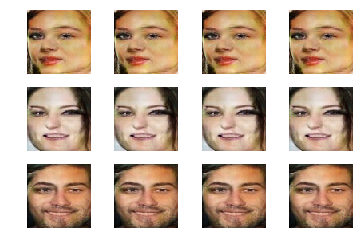

(100,)


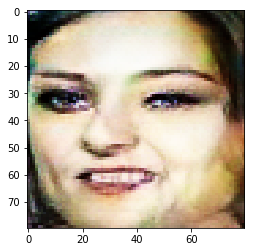

(100,)


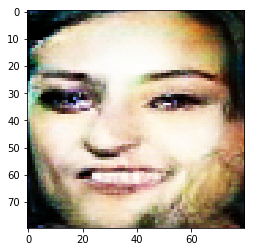

(100,)


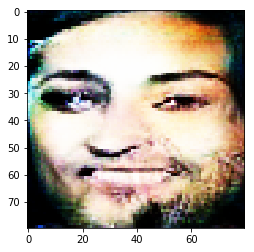

(100,)


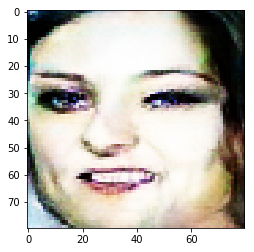

(100,)


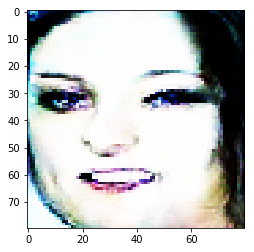

(100,)


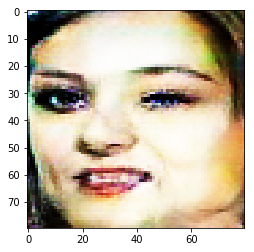

(100,)


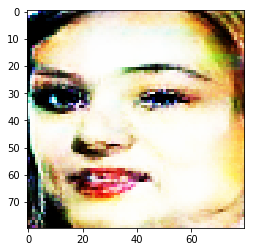

(100,)


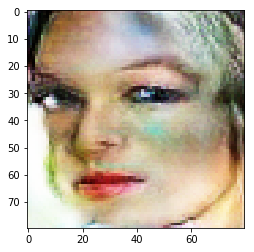

(100,)


(100,)


(100,)


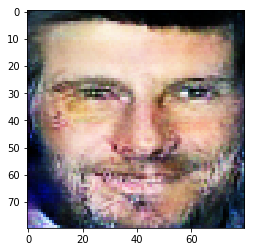

(100,)


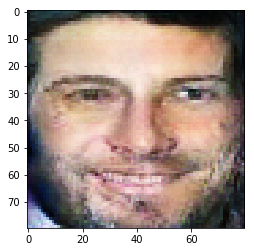

(100,)


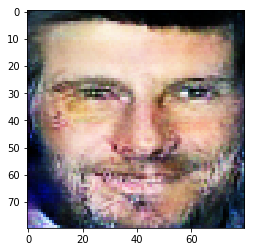

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [61, 61, 61]
neutral_woman_ix = [21, 21, 21] #[1, 21, 3]
neutral_man_ix = [7, 7, 7]  # [7, 30, 45]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)


result_vector =  smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 2* neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 4 * neutral_man[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =  smiling_woman[-1] + 2 * neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + 4 * neutral_woman[-1]   + neutral_man[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  2* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  4* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =  smiling_woman[-1] + neutral_woman[-1]   - 2*  neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   -  neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()






result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 4 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   + neutral_man[-1]  -  smiling_woman[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 





# The below 2 cells are for Generating a new Family with similar features. Image List of Brothers, Sisters, cousins, Aunts, uncles etc. Tried to create different age groups, 20's, 30, 40's etc. Also observer the person with simle , neutral and with out smile

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


(100,)


(100,)


(100,)


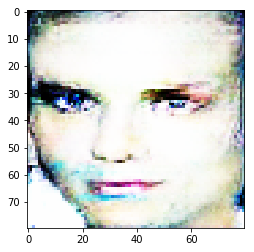

(100,)


(100,)


(100,)


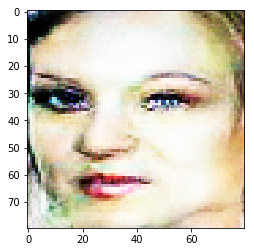

(100,)


(100,)


(100,)


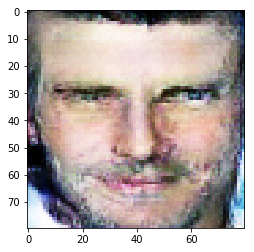

(100,)


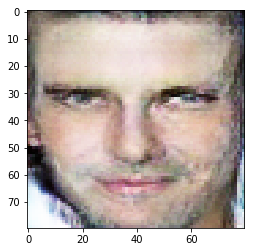

(100,)


(100,)


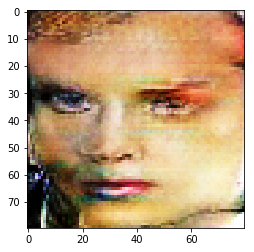

(100,)


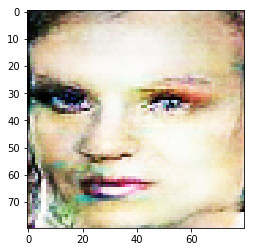

(100,)


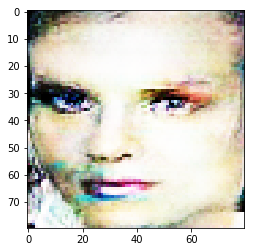

(100,)


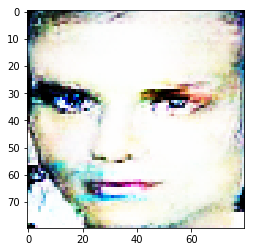

(100,)


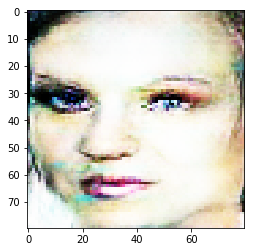

(100,)


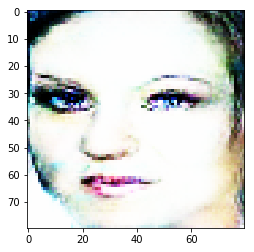

(100,)


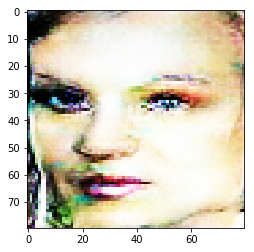

(100,)


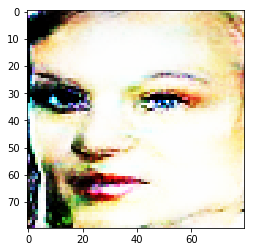

(100,)


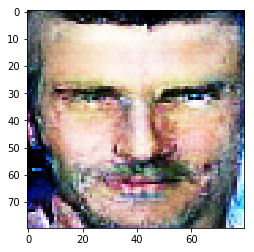

(100,)


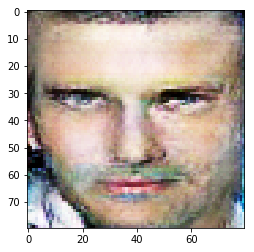

(100,)


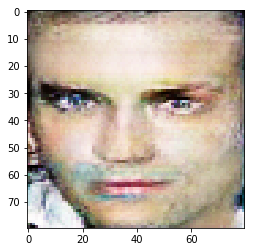

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [61, 61, 61]
neutral_woman_ix = [21, 21, 21] #[1, 21, 3]
neutral_man_ix = [100, 100, 100]  # [7, 30, 45]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)


result_vector =  smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 2* neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 4 * neutral_man[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 



result_vector =  smiling_woman[-1] + 2 * neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + 4 * neutral_woman[-1]   + neutral_man[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =  2* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  4* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


# result_vector =  smiling_woman[-1] + neutral_woman[-1]   - 2*  neutral_man[-1] 
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()
# result_vector =  smiling_woman[-1] + neutral_woman[-1]   -  neutral_man[-1] 
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()






result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 4 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   + neutral_man[-1]  -  smiling_woman[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()




# result_vector =    neutral_woman[-1]    - 4 * neutral_man[-1] +  smiling_woman[-1]
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show() 
# result_vector =    neutral_woman[-1]   - 2 * neutral_man[-1] +  smiling_woman[-1]
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show() 
# result_vector =   neutral_woman[-1]   - neutral_man[-1]  + smiling_woman[-1] 
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()



# result_vector =     neutral_man[-1] +  smiling_woman[-1]  - 4*neutral_woman[-1]  
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show() 
# result_vector =     neutral_man[-1] +  smiling_woman[-1]  - 2*neutral_woman[-1]
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show() 
result_vector =    neutral_man[-1]  + smiling_woman[-1] - neutral_woman[-1]   
new_vector = result_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =    neutral_man[-1]  + smiling_woman[-1] - neutral_woman[-1]   +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =  smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 2* neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 4 * neutral_man[-1]+  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 



result_vector =  smiling_woman[-1] + 2 * neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + 4 * neutral_woman[-1]   + neutral_man[-1]+  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =  2* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  4* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 4 * smiling_woman[-1]  +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]  +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   + neutral_man[-1]  -  smiling_woman[-1]   +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(4, 100) (4, 100)
(12, 80, 80, 3)
(12, 80, 80, 3)


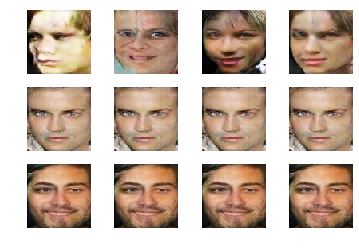

(100,)


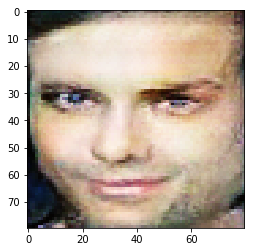

(100,)


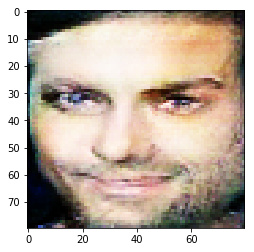

(100,)


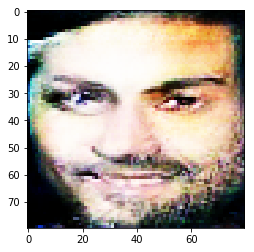

(100,)


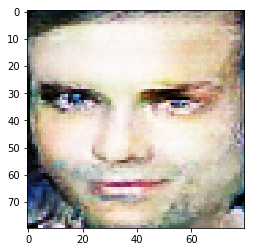

(100,)


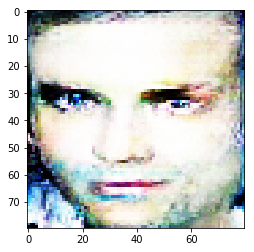

(100,)


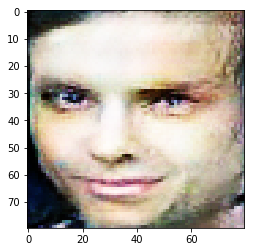

(100,)


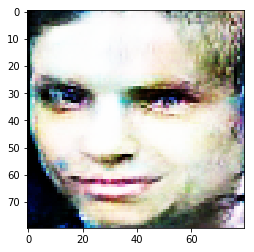

(100,)


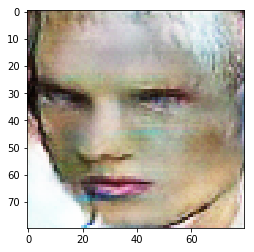

(100,)


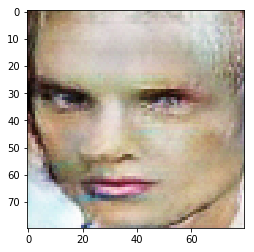

(100,)


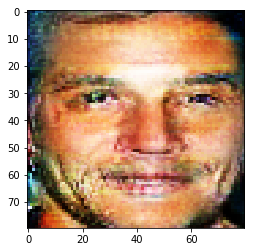

(100,)


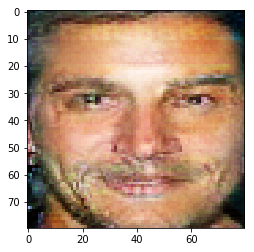

(100,)


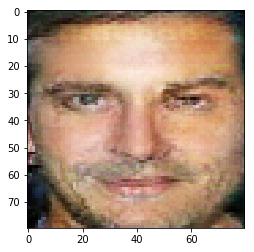

(100,)


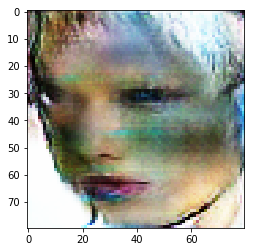

(100,)


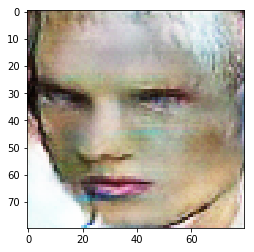

(100,)


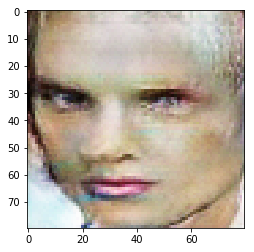

(100,)


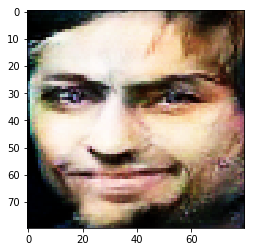

(100,)


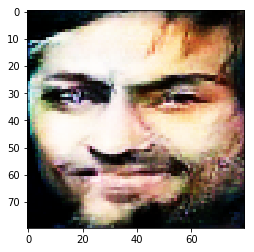

(100,)


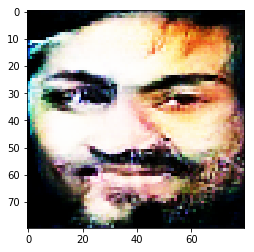

(100,)


(100,)


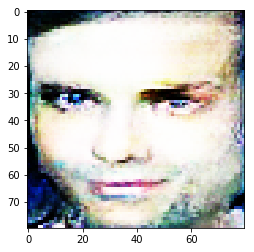

(100,)


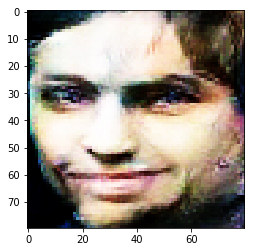

(100,)


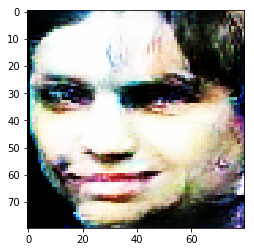

(100,)


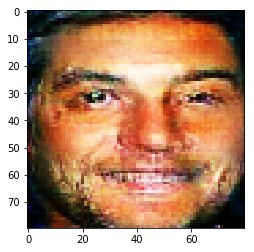

(100,)


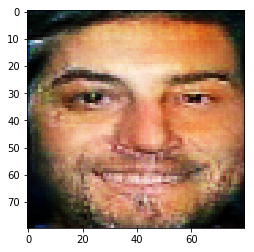

(100,)


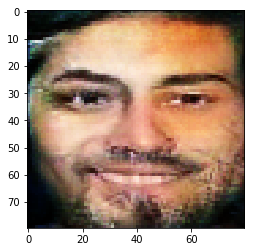

(100,)


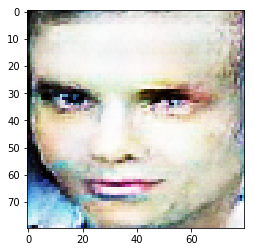

(100,)


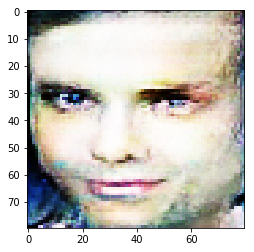

(100,)


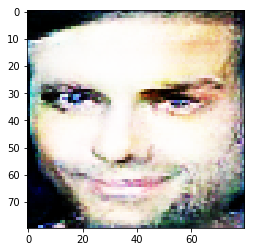

(100,)


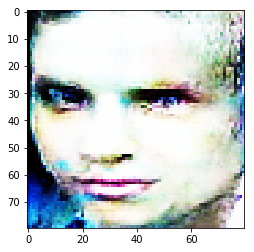

(100,)


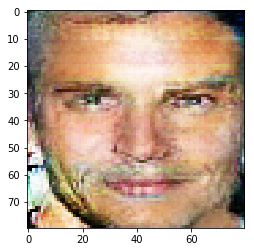

(100,)


(100,)


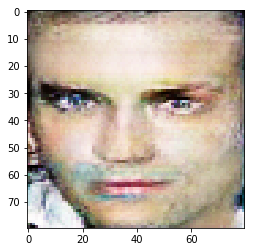

In [0]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	zero_ix = [i-1 for i in ix]
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_080.h5')
# retrieve specific points
smiling_woman_ix = [8, 10, 11]
neutral_woman_ix = [100,100,  100] #[1, 21, 3]
neutral_man_ix = [7,7,7,]  # [7, 30, 45]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
print(smiling_woman.shape,neutral_woman.shape )
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# # generate images
images = model.predict(all_vectors)
print(images.shape)
# # scale pixel values
images = (images + 1) / 2.0
print(images.shape)
plot_generated(images, 3, 4)


result_vector =  smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 2* neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 4 * neutral_man[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 



result_vector =  smiling_woman[-1] + 2 * neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + 4 * neutral_woman[-1]   + neutral_man[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =  2* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  4* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =  smiling_woman[-1] + neutral_woman[-1]   - 2*  neutral_man[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   -  neutral_man[-1] 
new_vector_9 = result_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()






result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 4 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   + neutral_man[-1]  -  smiling_woman[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()




result_vector =    neutral_woman[-1]    - 4 * neutral_man[-1] +  smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   - 2 * neutral_man[-1] +  smiling_woman[-1]
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   - neutral_man[-1]  + smiling_woman[-1] 
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



# result_vector =     neutral_man[-1] +  smiling_woman[-1]  - 4*neutral_woman[-1]  
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show() 
# result_vector =     neutral_man[-1] +  smiling_woman[-1]  - 2*neutral_woman[-1]
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show() 
# result_vector =    neutral_man[-1]  + smiling_woman[-1] - neutral_woman[-1]   
# new_vector = result_vector
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()


# result_vector =    neutral_man[-1]  + smiling_woman[-1] - neutral_woman[-1]   +  new_vector
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()


result_vector =  smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 2* neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 4 * neutral_man[-1]+  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 



result_vector =  smiling_woman[-1] + 2 * neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + 4 * neutral_woman[-1]   + neutral_man[-1]+  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =  2* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  4* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()



result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 4 * smiling_woman[-1]  +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]  +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   + neutral_man[-1]  -  smiling_woman[-1]   +  new_vector
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


#new_vector_9


result_vector =  smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 2* neutral_man[-1] +  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
result_vector =  smiling_woman[-1] + neutral_woman[-1]   + 4 * neutral_man[-1]+  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 



# result_vector =  smiling_woman[-1] + 2 * neutral_woman[-1]   + neutral_man[-1] +  new_vector_9
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()
# result_vector =  smiling_woman[-1] + 4 * neutral_woman[-1]   + neutral_man[-1]+  new_vector_9
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()



# result_vector =  2* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector_9
# print(result_vector.shape)
# # generate image
# result_vector = expand_dims(result_vector, 0)
# result_image = model.predict(result_vector)
# # scale pixel values
# result_image = (result_image + 1) / 2.0
# pyplot.imshow(result_image[0])
# pyplot.show()
result_vector =  4* smiling_woman[-1] + neutral_woman[-1]   + neutral_man[-1] +  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()


result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 4 * smiling_woman[-1]  +  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =    neutral_woman[-1]   + neutral_man[-1]  - 2 * smiling_woman[-1]  +  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show() 
result_vector =   neutral_woman[-1]   + neutral_man[-1]  -  smiling_woman[-1]   +  new_vector_9
print(result_vector.shape)
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()
